<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/18a_Light_RNN_%D0%B8_CNN_%D0%B2_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.

1. Embedding + LSTM сеть.
2. Embedding + Conv1D сеть.
3. Embedding + сложная сеть из Dense, LSTM и Conv1D.

Добейтесь максимальной точности распознавания.

Используйте xLen = 50.

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции

In [ ]:
# Чтение файла + запись в одну строку
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  text = text.replace('\n', ' ')
  return text


# Функции для формирования выборки по отрезкам текста с заданным шагом
# Разделение на короткие векторы
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  #Идем по всей длине вектора индексов и откусываем векторы длиной xLen , смещаемся на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  return xSample

# Формирование обучающей и проверочной выборки из двух листов индексов от двух классов

def createSetsMultiClasses (wordIndexes, xLen, step):
  #Для каждого из 10 классов создаем обучающую и проверочную выборки из индексов
  nClasses = len(wordIndexes) #задали количество классов выборки
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  #Создаем один общий xSamples
  xSamples = []   # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = []   # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range (nClasses):   # в диапазоне кол-ва классов(10)
    xT = classesXSamples[t]    # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range (len(xT)):  # и каждое его окно
      xSamples.append(xT[i])   # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса  
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 10 вида [0.0.0.0.0.0.0.1.0.0.]
    for i in range(len(xT)):   # на каждое окно выборки 
      ySamples.append(currY)   # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples) # функция возвращает выборку и соответствующие векторы классов

# Представляем тестовую выборку в удобных для распознавания размерах
 
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
   
  xTest10Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(10 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest10Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
     
   
  return  xTest10Classes # функция вернёт тестовые данные: xTestEm 10 по n*1000





In [ ]:
# График 

def show_res():
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['loss'], 
          label='Значение ошибки на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.show()

  # Строим график для отображения динамики обучения и точности предсказания сети
  plt.figure(figsize = (14, 7))
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

# Загрузка данных


In [ ]:
className = ['Аппендицит', 'Гастрит', 'Гепатит', 'Дуоденит', 'Колит', 'Панкреатит', 'Холицестит', 'Эзофагит', 'Энтерит', 'Язва']
nClasses = len(className)

In [ ]:
import os

trainText = []
testText = []

for i in className:
 for j in os.listdir('disease/'): 
    if i in j: 
      text = readText('disease/' + j)
      #print(j, len(text))      
      #text = text[:3460]
      index = int(len(text)*0.2) #отделяем тестовую часть
      print(j, len(text))
      trainText.append(text[index:]) # создаем обучающую выборку
      testText.append(text[:index])  # создаем тестовую выборку


print(len(trainText)) # Количество элементов в trainText
print(len(trainText[0])) # Количество символов в первом источнике в trainText
print(len(testText))
print(len(testText[0]))     

Аппендицит.txt 4075
Гастрит.txt 6717
Гепатит.txt 5523
Дуоденит.txt 3941
Колит.txt 9127
Панкреатит.txt 11313
Холицестит.txt 6157
Эзофагит.txt 5867
Энтерит.txt 6383
Язва.txt 3460
10
3260
10
815


# Обработка данных


In [ ]:
# Преобразуем данные в числовые/векторные
maxWordsCount = 20000

tokenizer = Tokenizer(num_words=maxWordsCount, filters = '–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower = True, split = ' ', char_level = False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова
tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:20]) # взглянем на содержимое словаря

[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('или', 5), ('тошнота', 6), ('боли', 7), ('рвота', 8), ('живота', 9), ('при', 10), ('после', 11), ('отрыжка', 12), ('области', 13), ('животе', 14), ('с', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('тела', 19), ('может', 20)]


In [ ]:
# Преобразовываем  текст в последовательность индексов согласно словарю частотности
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

# Создание обучающей и проверочной выборки

In [ ]:
# Задаём длину окна и шаг
xLen = 50 # Длина отрезка текста, по которой анализируем, в словах
step = 5 # Шаг разбиения исходного текста на обучающие вектора
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(1218, 50)
(1218, 10)
(237, 50)
(237, 10)


In [ ]:
print(xTrain[0], yTrain[0])
print(xTest[0], yTest[0])

[202  91 134  39  92 744  32 745 325 326  32  93  41  17   6   8  32  33
  19  53   5  26   4   2  14   6   8  39   3 472  70 746 473 327 474  10
 475 328  35  19 159  27 202 203 747 249 476 748 477   2] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 175    4    2   14   32   33    1  231    6  122    4    2   14    2
  541 1022    3   10 1802   32   33    6    8  383    4    1   95    5
   40   42    9   52  136  265    1    2  489  490  771    9   84  300
 1243  653   41   17    6    3    5    8] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Эксперименты

## Embedding + LSTM  

####**Иссл. №1**

In [ ]:
print(xTrain.shape)

(1218, 50)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 80)            1600000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 80)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 80)            320       
_________________________________________________________________
lstm (LSTM)                  (None, 50)                26200     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 1,627,030
Trainable params: 1,626,870
Non-trainable params: 160
_________________________________________________________________



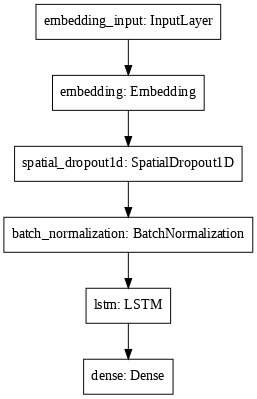

In [ ]:
model_Emb_LSTM_1 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_LSTM_1.add(Embedding(maxWordsCount, 80, input_length=xLen))

model_Emb_LSTM_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_LSTM_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_LSTM_1.add(LSTM(50))
model_Emb_LSTM_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_LSTM_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



model_Emb_LSTM_1.summary()
print()
plot_model(model_Emb_LSTM_1, dpi=70)


In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_LSTM_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
20/20 [==============================] - 5s 27ms/step - loss: 2.0607 - accuracy: 0.3489 - val_loss: 3.0509 - val_accuracy: 0.2152
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 1.1972 - accuracy: 0.7521 - val_loss: 3.4549 - val_accuracy: 0.2152
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6600 - accuracy: 0.9187 - val_loss: 4.0488 - val_accuracy: 0.1688
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3792 - accuracy: 0.9721 - val_loss: 4.3272 - val_accuracy: 0.2447
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2264 - accuracy: 0.9910 - val_loss: 4.3878 - val_accuracy: 0.2616
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1280 - accuracy: 0.9967 - val_loss: 3.2669 - val_accuracy: 0.2785
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0760 - accuracy: 1.0000 - val_loss: 2.9838 - val_accuracy: 0.3671
Epoch 8/100


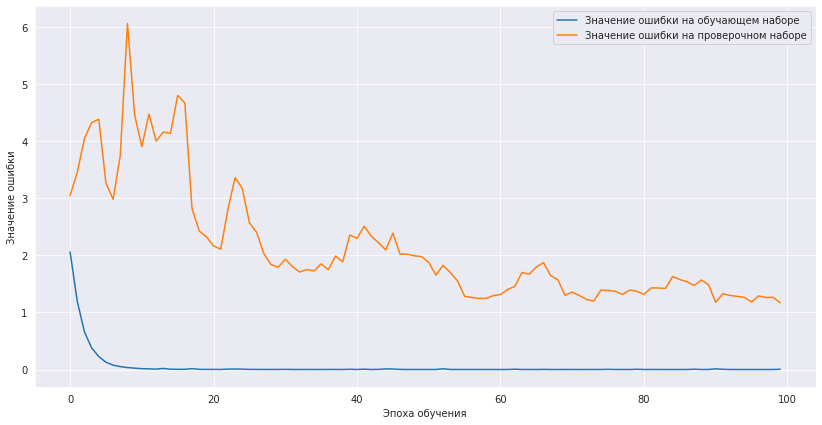

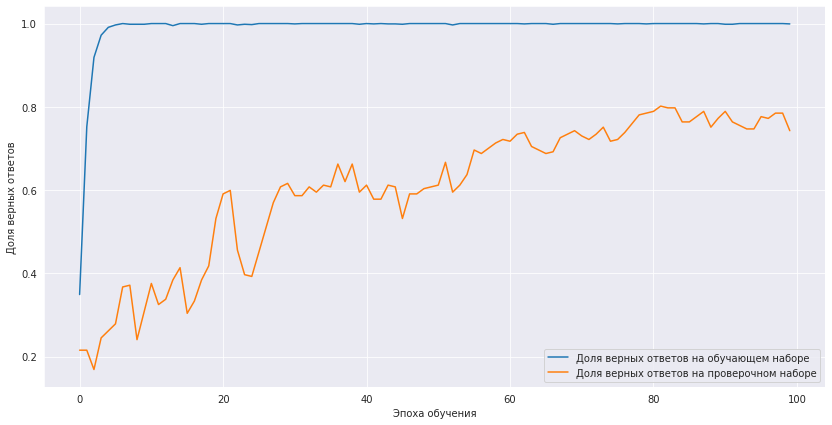

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

####**Иссл. №2**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 150)           3000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 150)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 150)           600       
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 3,102,010
Trainable params: 3,101,710
Non-trainable params: 300
__________________________________________

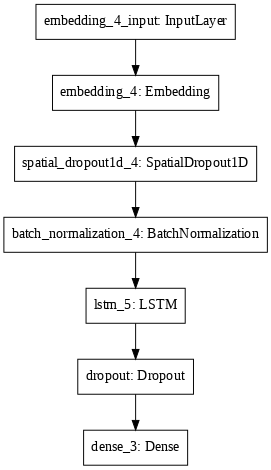

In [ ]:
model_Emb_LSTM_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Emb_LSTM_2.add(Embedding(maxWordsCount, 150, input_length=xLen))

model_Emb_LSTM_2.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Emb_LSTM_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Emb_LSTM_2.add(LSTM(100))
model_Emb_LSTM_2.add(Dropout(0.5))
model_Emb_LSTM_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Emb_LSTM_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



model_Emb_LSTM_2.summary()
print()
plot_model(model_Emb_LSTM_2, dpi=70)


In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Emb_LSTM_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
20/20 [==============================] - 2s 28ms/step - loss: 2.1440 - accuracy: 0.2323 - val_loss: 3.2326 - val_accuracy: 0.1603
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 1.3036 - accuracy: 0.6215 - val_loss: 4.4477 - val_accuracy: 0.2616
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.7108 - accuracy: 0.8218 - val_loss: 4.8532 - val_accuracy: 0.2658
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.3402 - accuracy: 0.9302 - val_loss: 4.6683 - val_accuracy: 0.2827
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1971 - accuracy: 0.9737 - val_loss: 4.4285 - val_accuracy: 0.3122
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0985 - accuracy: 0.9959 - val_loss: 4.6354 - val_accuracy: 0.3249
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9975 - val_loss: 4.2282 - val_accuracy: 0.3882
Epoch 8/100


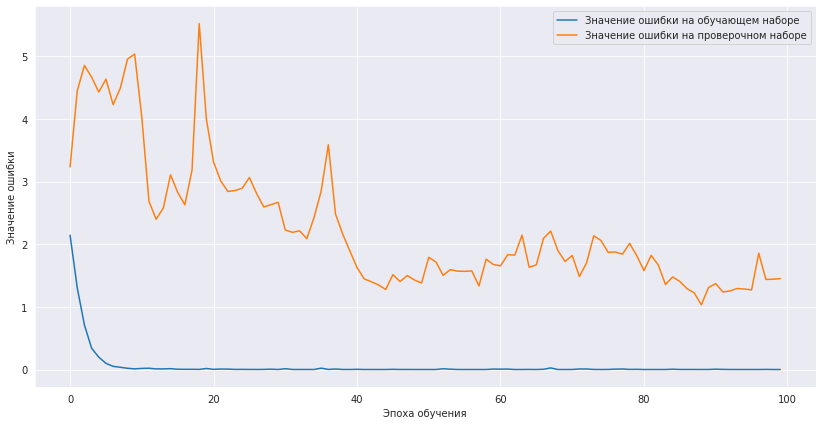

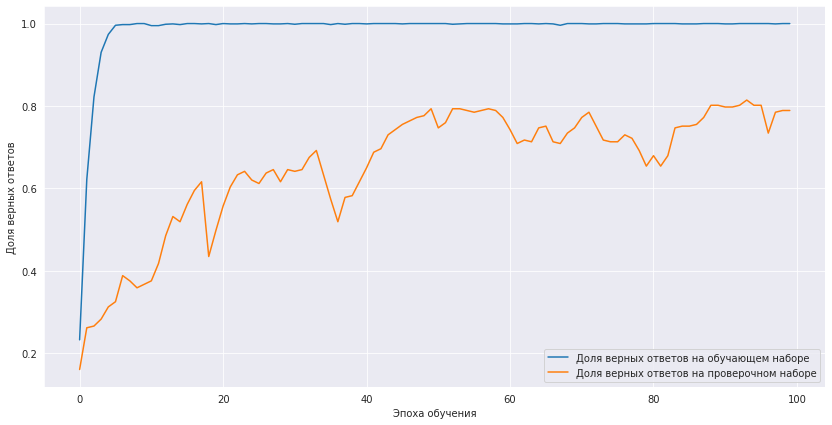

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

## Embedding + Conv1D

####**Иссл. №3**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 50, 50)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 50, 50)            200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 50, 20)            5020      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 20)            2020      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 23, 20)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 20)           

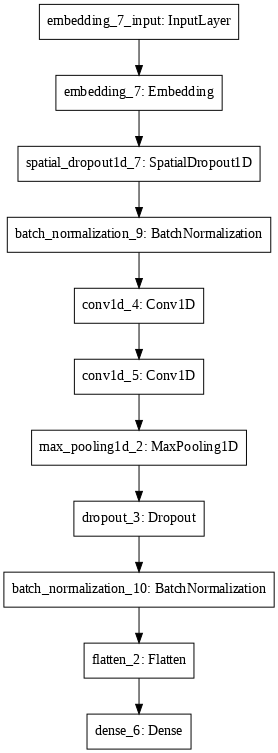

In [ ]:
model_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_1.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Conv_1.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_1.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_1.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(Dropout(0.4)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_1.summary()
print()
plot_model(model_Conv_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
20/20 [==============================] - 1s 14ms/step - loss: 2.9937 - accuracy: 0.0985 - val_loss: 2.2946 - val_accuracy: 0.1350
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 2.5127 - accuracy: 0.1798 - val_loss: 2.3102 - val_accuracy: 0.0970
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 2.1436 - accuracy: 0.2619 - val_loss: 2.3379 - val_accuracy: 0.0970
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 1.6580 - accuracy: 0.4302 - val_loss: 2.3620 - val_accuracy: 0.0970
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 1.1687 - accuracy: 0.5837 - val_loss: 2.4311 - val_accuracy: 0.0970
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.7922 - accuracy: 0.7603 - val_loss: 2.5510 - val_accuracy: 0.0970
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5458 - accuracy: 0.8489 - val_loss: 2.6947 - val_accuracy: 0.0970
Epoch 8/100


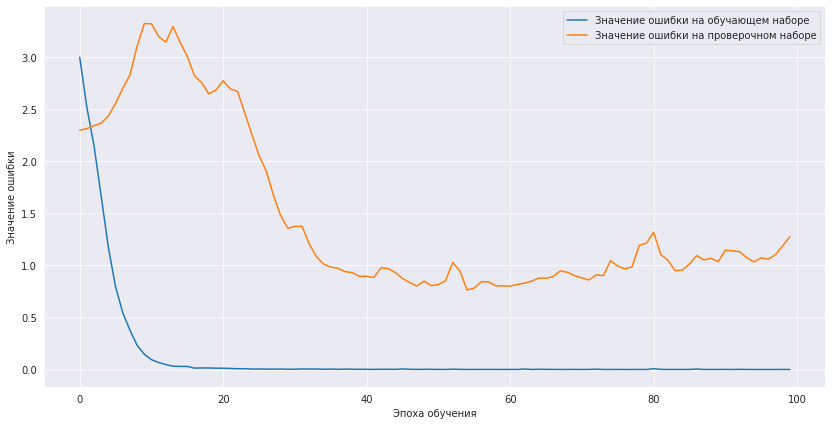

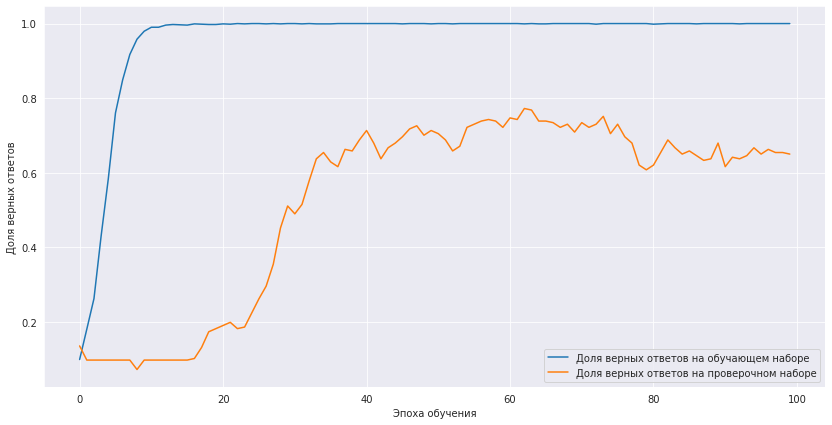

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

####**Иссл. №4**

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 150)           3000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 50, 150)           0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 50, 150)           600       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 40)            48040     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 43, 40)            12840     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 40)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 40)           

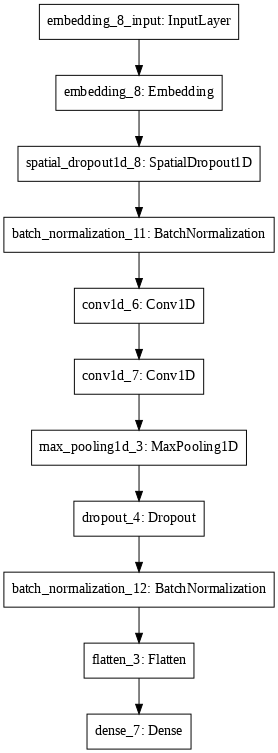

In [ ]:
model_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_1.add(Embedding(maxWordsCount, 150, input_length=xLen))

model_Conv_1.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_1.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_1.add(Conv1D(40, 8, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(Conv1D(40, 8, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(MaxPooling1D(3)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_1.summary()
print()
plot_model(model_Conv_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
20/20 [==============================] - 1s 15ms/step - loss: 2.9508 - accuracy: 0.1076 - val_loss: 2.2762 - val_accuracy: 0.2236
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 2.2576 - accuracy: 0.2603 - val_loss: 2.2712 - val_accuracy: 0.2152
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 1.5769 - accuracy: 0.4639 - val_loss: 2.2761 - val_accuracy: 0.2152
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0110 - accuracy: 0.6675 - val_loss: 2.3534 - val_accuracy: 0.2152
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5311 - accuracy: 0.8571 - val_loss: 2.4927 - val_accuracy: 0.2363
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2665 - accuracy: 0.9425 - val_loss: 2.5726 - val_accuracy: 0.2954
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1332 - accuracy: 0.9762 - val_loss: 2.6699 - val_accuracy: 0.2869
Epoch 8/100


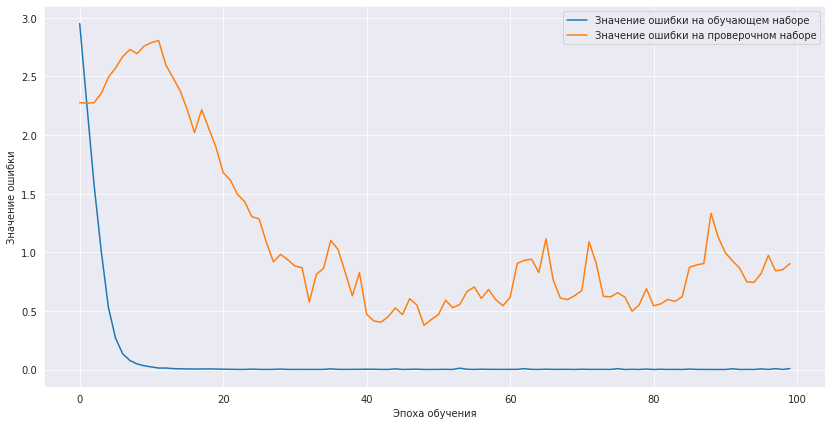

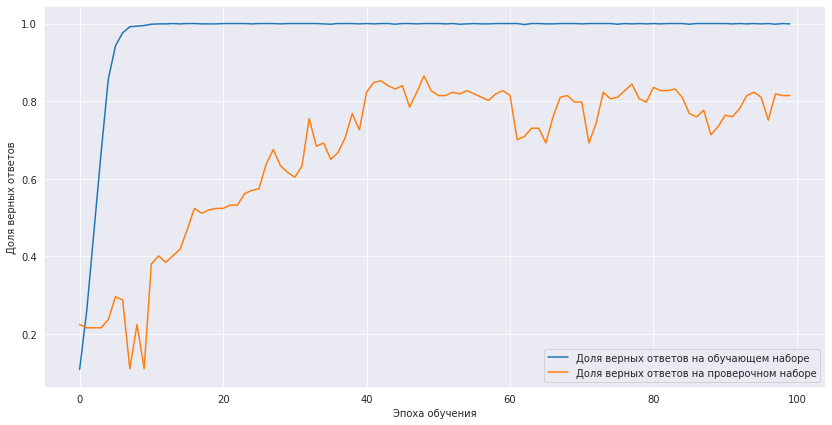

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

## Embedding + сложная сеть из Dense, LSTM и Conv1D

####**Иссл. №5**

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 50)            1000000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 50, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 4)             880       
_________________________________________________________________
dense_12 (Dense)             (None, 50, 100)           500       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 46, 20)            10020     
_________________________________________________________________
lstm_11 (LSTM)               (None, 46, 4)             400       
_________________________________________________________________
dropout_9 (Dropout)          (None, 46, 4)           

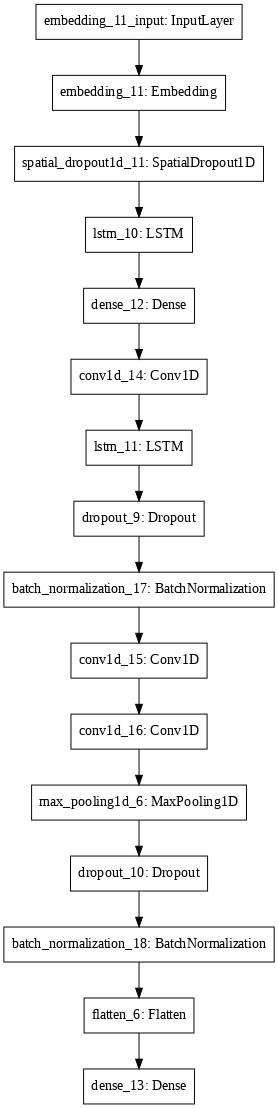

In [ ]:
model_LC_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_1.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_LC_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_1.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LC_1.summary()
print()
plot_model(model_LC_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0113 - accuracy: 0.9967 - val_loss: 4.2889 - val_accuracy: 0.5021
Epoch 2/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 4.0747 - val_accuracy: 0.5316
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0213 - accuracy: 0.9959 - val_loss: 4.8009 - val_accuracy: 0.4852
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0465 - accuracy: 0.9869 - val_loss: 3.7551 - val_accuracy: 0.5570
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0222 - accuracy: 0.9926 - val_loss: 4.2703 - val_accuracy: 0.4937
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0230 - accuracy: 0.9943 - val_loss: 3.8134 - val_accuracy: 0.4430
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0329 - accuracy: 0.9910 - val_loss: 5.9791 - val_accuracy: 0.4388
Epoch 

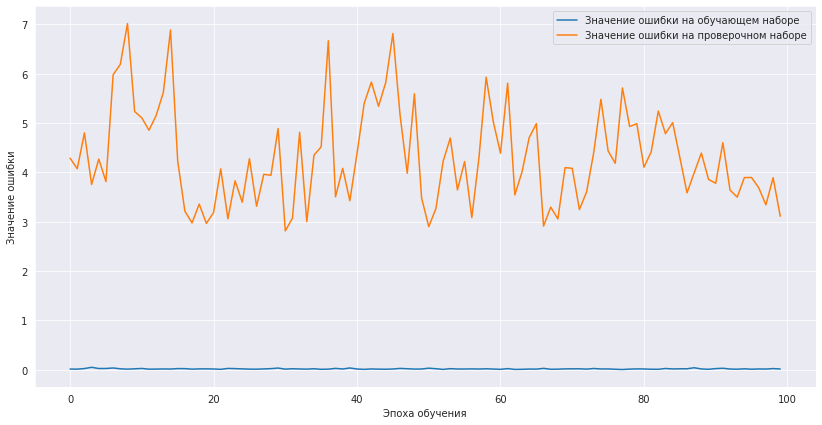

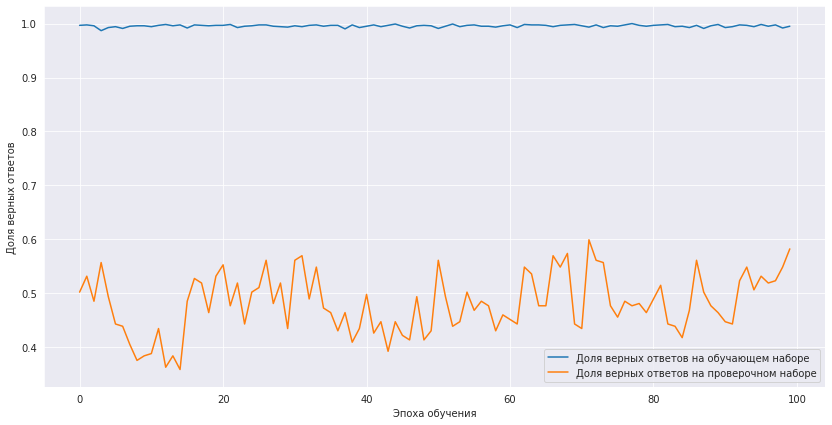

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

####**Иссл. №6**

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 150)           3000000   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 50, 150)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 4)             2480      
_________________________________________________________________
dense_20 (Dense)             (None, 50, 100)           500       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 46, 20)            10020     
_________________________________________________________________
lstm_19 (LSTM)               (None, 46, 20)            3280      
_________________________________________________________________
dropout_17 (Dropout)         (None, 46, 20)          

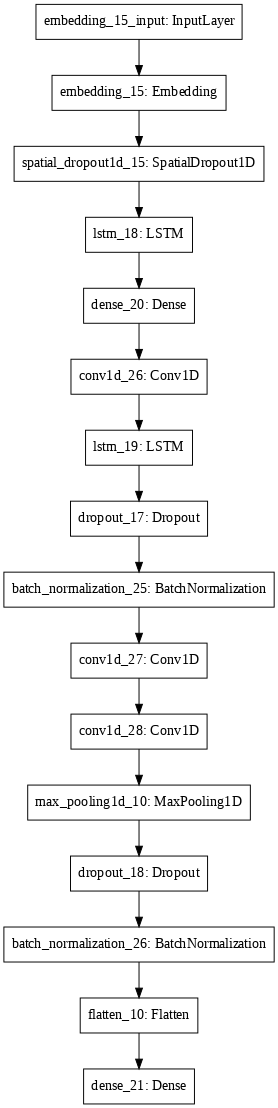

In [ ]:
model_LC_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_2.add(Embedding(maxWordsCount, 150, input_length=xLen))

model_LC_2.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_2.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_2.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(LSTM(20, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_2.add(Dropout(0.4)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(MaxPooling1D(3)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_2.add(Dropout(0.4)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_2.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LC_2.summary()
print()
plot_model(model_LC_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 3.8410 - val_accuracy: 0.5316
Epoch 2/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0263 - accuracy: 0.9926 - val_loss: 2.8183 - val_accuracy: 0.5359
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 3.0096 - val_accuracy: 0.6456
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 3.8657 - val_accuracy: 0.5570
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0205 - accuracy: 0.9918 - val_loss: 2.9347 - val_accuracy: 0.6371
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 3.1448 - val_accuracy: 0.5865
Epoch 7/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0086 - accuracy: 0.9984 - val_loss: 2.9542 - val_accuracy: 0.5949
Epoch 

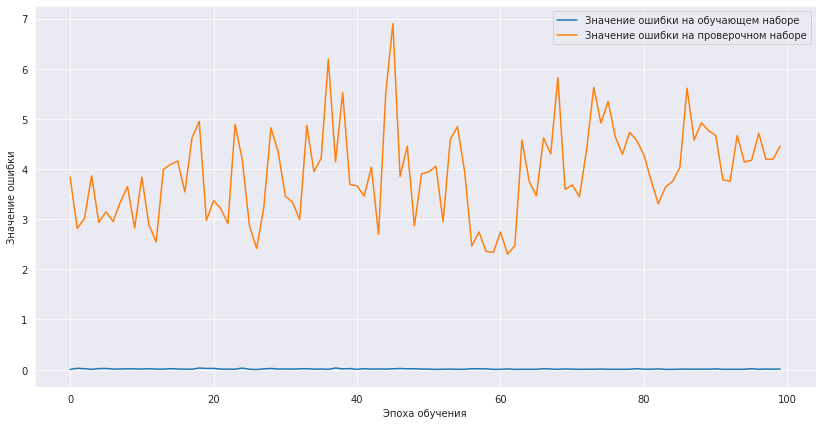

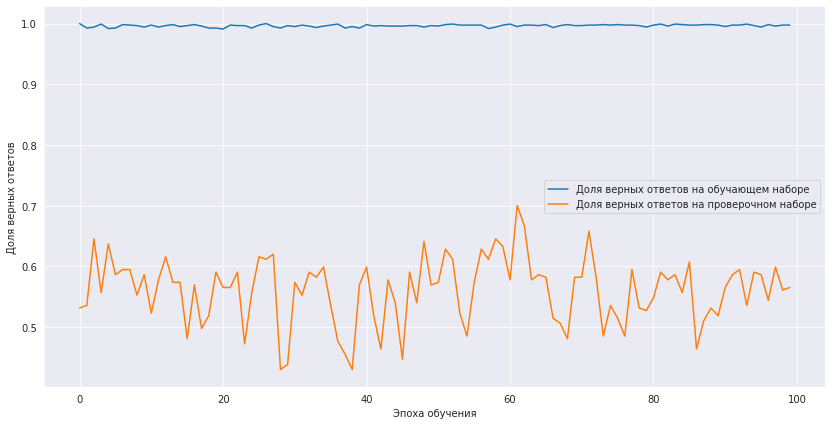

In [ ]:
# Строим график для отображения динамики ошибки работы модели
show_res()

# Вывод

Сложные архитектуры не дают преимущества, на графике видна тенденция к переобучению . Свертки и увеличение слоя Embedding могут повысить точность, также требуется увеличивать Dropout, чтобы побороть переобучение с увеличением значений в слоях.